# ITCH NASDAQ order analysis

In [1]:
from FSociety.Config import datapath, ITCH_days
from FSociety.Util import nanoseconds_to_time, capped_prices
from FSociety.ITCH import ITCHtime, ITCHMessages
from FSociety.Data import Company, Stock,MPI, OrdersProcessor, Order, OrdersCounter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
import gzip

st = Stock(num=50)
print(sorted(st.get_list_stocks()))

['AAPL', 'ABX', 'AMD', 'AMZN', 'ATVI', 'BAC', 'BBL', 'C', 'CSCO', 'DIA', 'EWZ', 'FAS', 'FB', 'GDX', 'GDXJ', 'GILD', 'GLD', 'GOOG', 'GOOGL', 'INTC', 'IVV', 'IWM', 'JNUG', 'JPM', 'KRE', 'MS', 'MSFT', 'MU', 'NEM', 'NUGT', 'NVDA', 'QLD', 'QQQ', 'RIO', 'SPY', 'SSO', 'TLT', 'TNA', 'UCO', 'UVXY', 'VOO', 'VXX', 'WFC', 'X', 'XIV', 'XLE', 'XLV', 'XLY', 'XOP', 'YHOO']


In [2]:
def plot_tscale():
    plt.plot([3,3],[0,0.1], 'r')
    plt.plot([6,6],[0,0.1], 'r')
    plt.plot([9,9],[0,0.1], 'r')
    plt.plot([10,10],[0,0.05], 'g')
    plt.plot([11,11],[0,0.05], 'g')

In [3]:
stock = 'AMZN'
day = 0
year = '2017G'
itchday = ITCH_days[year][day]


cmp = Company()
print(cmp.get_company(stock))

rfile = ITCHMessages(year, day, stock)
rfile.open()
sorders = OrdersProcessor()

['Amazon.com- Inc.', 'Consumer Services', 'Catalog/Specialty Distribution', 'NASDAQ']


In [76]:
lexecutionsS = []
lexecutionsB = []
ltimeOS = []
ltimeOB = []
lpriceOS = []
lpriceOB = []
lsizeOB = []
lsizeOS = []
ldelete = []

ltimeEB = []
ltimeES = []
lpriceES = []
lpriceEB = []
ltimeEP = []  # Ordenes ocultas
lpriceEP = []
lsizeEB = []
lsizeES = []
lsizeEP = []

sorders = OrdersProcessor(history=True)

i = 0
norders = 0

rfile = ITCHMessages(year, day, stock)
sorders = OrdersProcessor()
rfile.open()


for order in rfile.get_order():
    sorders.insert_order(order)

    if order.type in ['F', 'A', 'U']:
        norders += 1
        if 0.5 < order.price < 1000:
            if order.buy_sell == 'B':
                lpriceOB.append(order.price)
                ltimeOB.append(order.otime)
                lsizeOB.append(order.size)
            else:
                lpriceOS.append(order.price)
                ltimeOS.append(order.otime)
                lsizeOS.append(order.size)

    # Computes the time between placing and order and canceling it
    if order.type == 'D':
        trans = sorders.query_id(order.id)
        if trans is not None:
            ldelete.append(order.otime - trans.otime)
        else:
            print('MISSING DELETED' + order.id)

    # Computes the time between placing and order and its execution
    if order.type in ['E', 'C']:
        trans = sorders.query_id(order.id)
        if trans.buy_sell == 'S':
            lexecutionsS.append(order.otime - trans.otime)
            ltimeES.append(order.otime)
            lpriceES.append(trans.price)
            lsizeES.append(trans.size)
        else:
            lexecutionsB.append(order.otime - trans.otime)
            ltimeEB.append(order.otime)
            lpriceEB.append(trans.price)
            lsizeEB.append(trans.size)

    # Non-displayable orders
    if order.type in ['P']:
        ltimeEP.append(order.otime)
        lpriceEP.append(order.price)
        lsizeEP.append(order.size)

2017G 0


In [77]:
print('Stock:', stock, 'Day:', itchday)
print('N Buy orders:', len(ltimeOB))
print('N Sell orders:', len(ltimeOS))
print('N Order Executions Sell:', len(lexecutionsS))
print('Mean time to execution:', nanoseconds_to_time(np.mean(lexecutionsS)))
print('Max time to execution:', nanoseconds_to_time(np.max(lexecutionsS)))
print('Min time to execution:', nanoseconds_to_time(np.min(lexecutionsS)))
print('N Order Executions Buy:', len(lexecutionsB))
print('Mean time to execution:', nanoseconds_to_time(np.mean(lexecutionsB)))
print('Max time to execution:', nanoseconds_to_time(np.max(lexecutionsB)))
print('Min time to execution:', nanoseconds_to_time(np.min(lexecutionsB)))
print('N Hiden Executions:', len(ltimeEP))

Stock: AMZN Day: 020117
N Buy orders: 129171
N Sell orders: 97670
N Order Executions Sell: 5885
Mean time to execution: 00:10:13.449.910.955
Max time to execution: 08:13:48.940.650.020
Min time to execution: 00:00:00.000.003.620
N Order Executions Buy: 5236
Mean time to execution: 00:03:39.934.739.103
Max time to execution: 02:38:43.528.005.695
Min time to execution: 00:00:00.000.001.153
N Hiden Executions: 4913


<IPython.core.display.Javascript object>


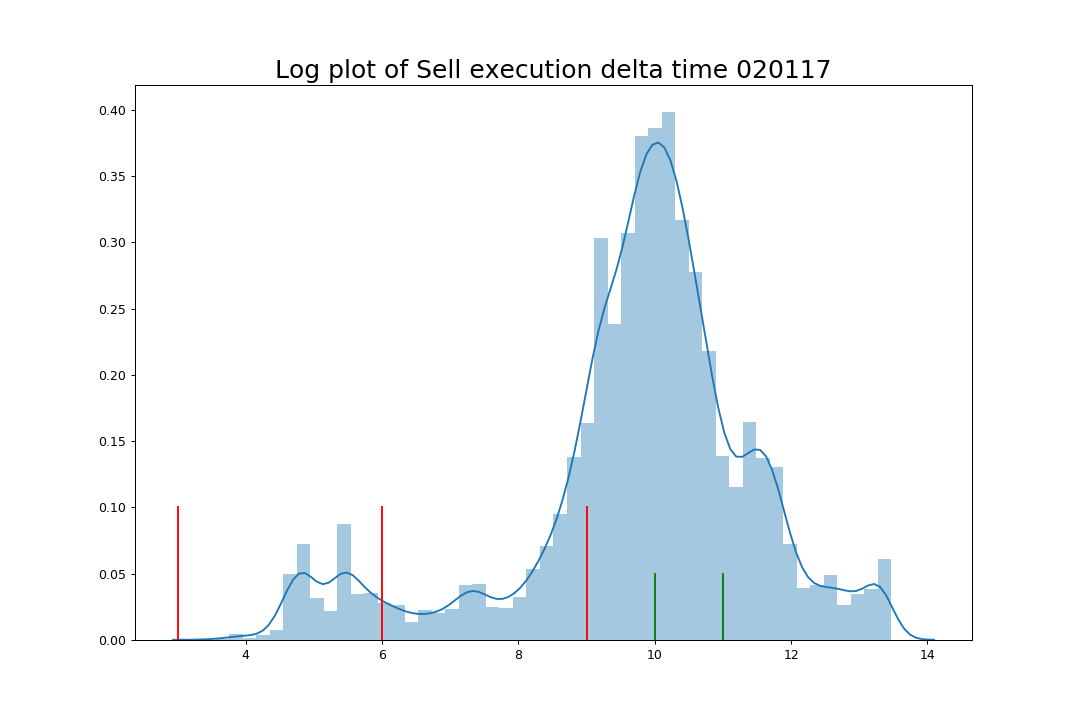

In [89]:
fig = plt.figure(figsize=(12,8))
ax = sns.distplot(np.log10(lexecutionsS), kde=True, norm_hist=True)
plot_tscale()
plt.title('Log plot of Sell execution delta time ' + itchday, fontsize=20)
plt.show()

<IPython.core.display.Javascript object>


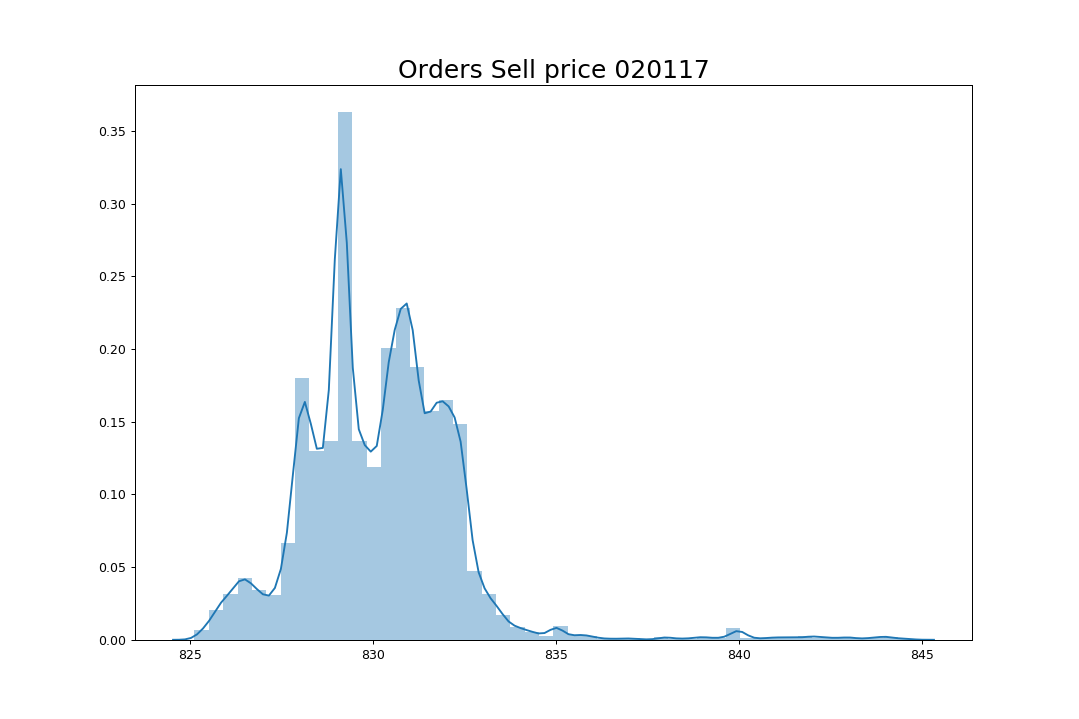

In [90]:
fig = plt.figure(figsize=(12,8))
ax = sns.distplot(capped_prices(lpriceOS),  kde=True, norm_hist=True)
plt.title('Orders Sell price ' + itchday, fontsize=20)
plt.show()

<IPython.core.display.Javascript object>


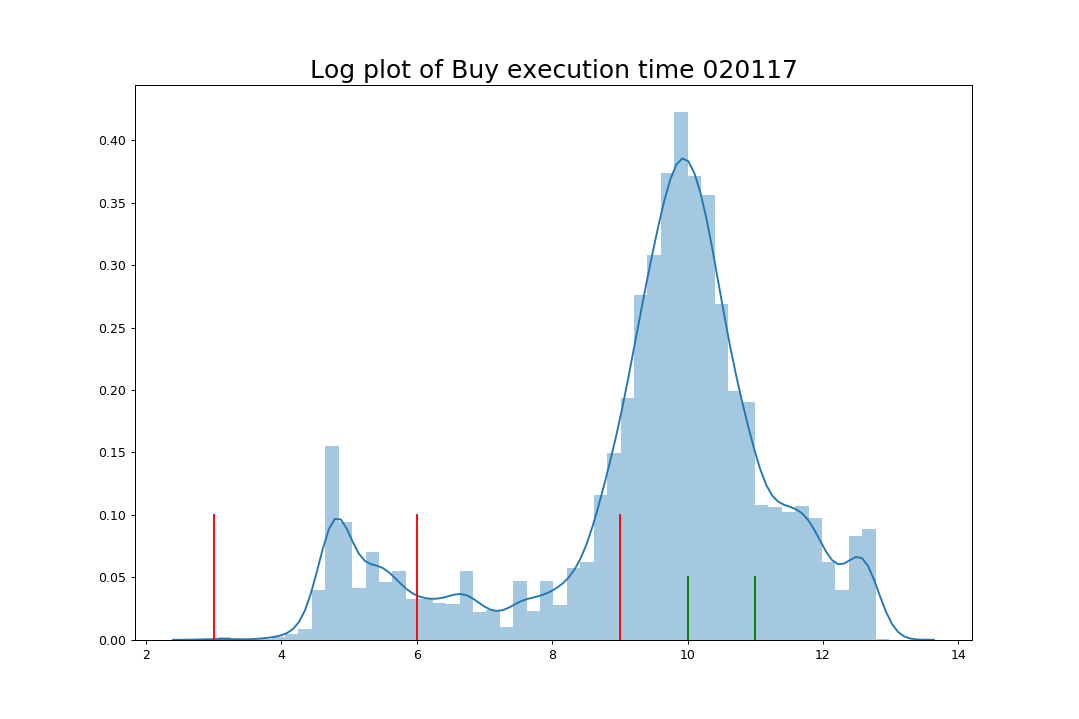

In [91]:
fig = plt.figure(figsize=(12,8))
ax = sns.distplot(np.log10(lexecutionsB),  kde=True, norm_hist=True)
plot_tscale()
plt.title('Log plot of Buy execution time ' + itchday, fontsize=20)
plt.show()

<IPython.core.display.Javascript object>


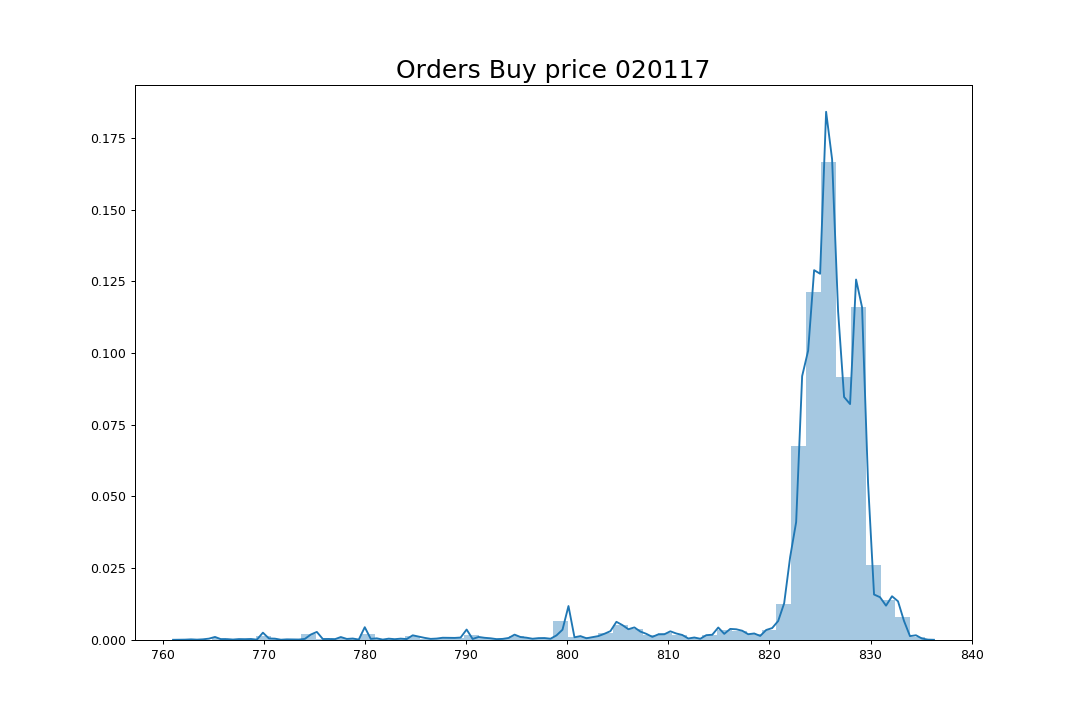

In [92]:
fig = plt.figure(figsize=(12,8))
ax = sns.distplot(capped_prices(lpriceOB),  kde=True, norm_hist=True)
plt.title('Orders Buy price ' + itchday, fontsize=20)
plt.show()

<IPython.core.display.Javascript object>


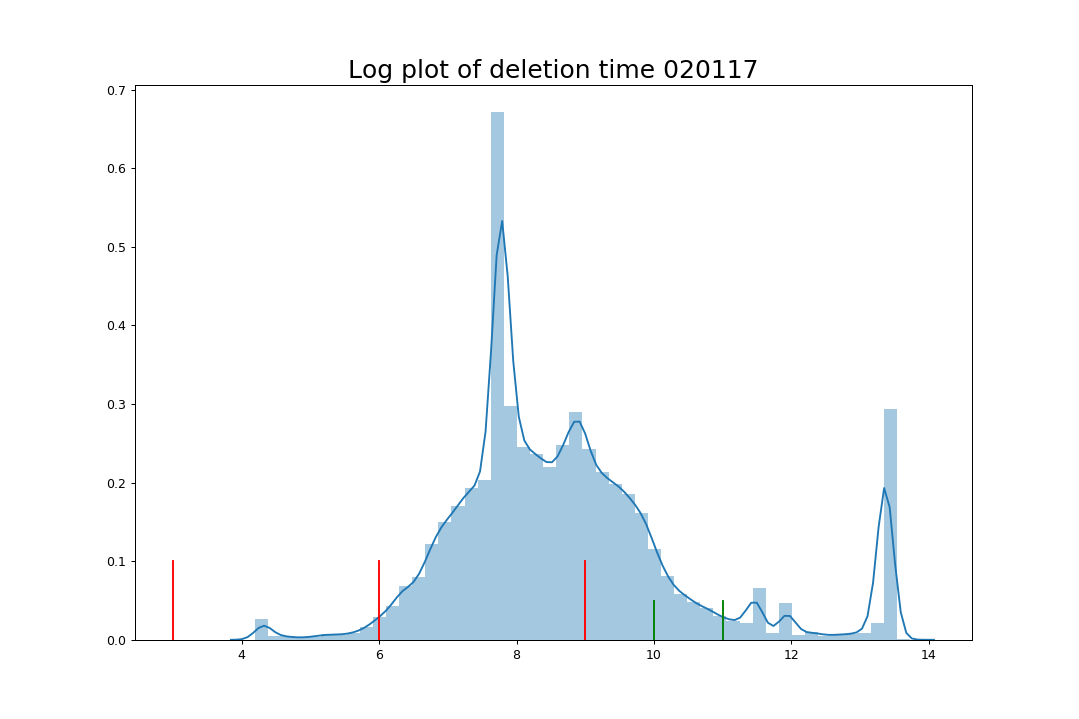

In [93]:
fig = plt.figure(figsize=(12,8))
ax = sns.distplot(np.log10(ldelete), kde=True, norm_hist=True)
plot_tscale()
plt.title('Log plot of deletion time ' + itchday, fontsize=20)
plt.show()

<IPython.core.display.Javascript object>


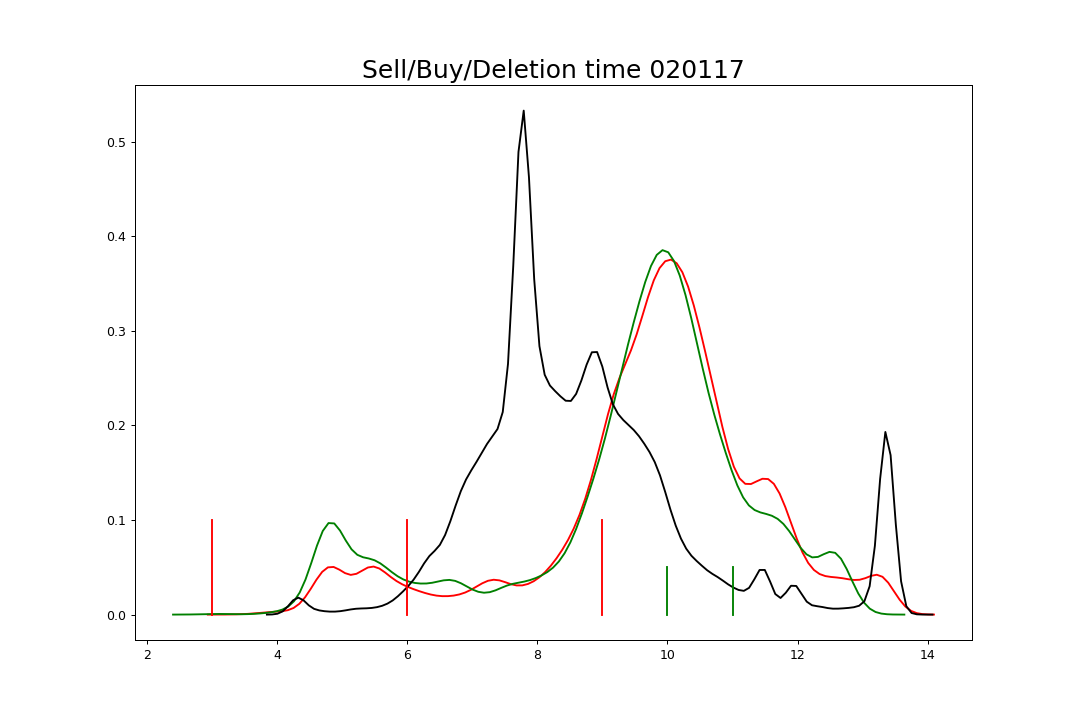

In [94]:
fig = plt.figure(figsize=(12,8))
ax = sns.distplot(np.log10(lexecutionsS),  kde=True, hist=False, color='r')
ax = sns.distplot(np.log10(lexecutionsB),  kde=True, hist=False, color='g')
ax = sns.distplot(np.log10(ldelete),  kde=True, hist=False, color='k')
plot_tscale()
plt.title('Sell/Buy/Deletion time ' + itchday, fontsize=20)
plt.show()

<IPython.core.display.Javascript object>


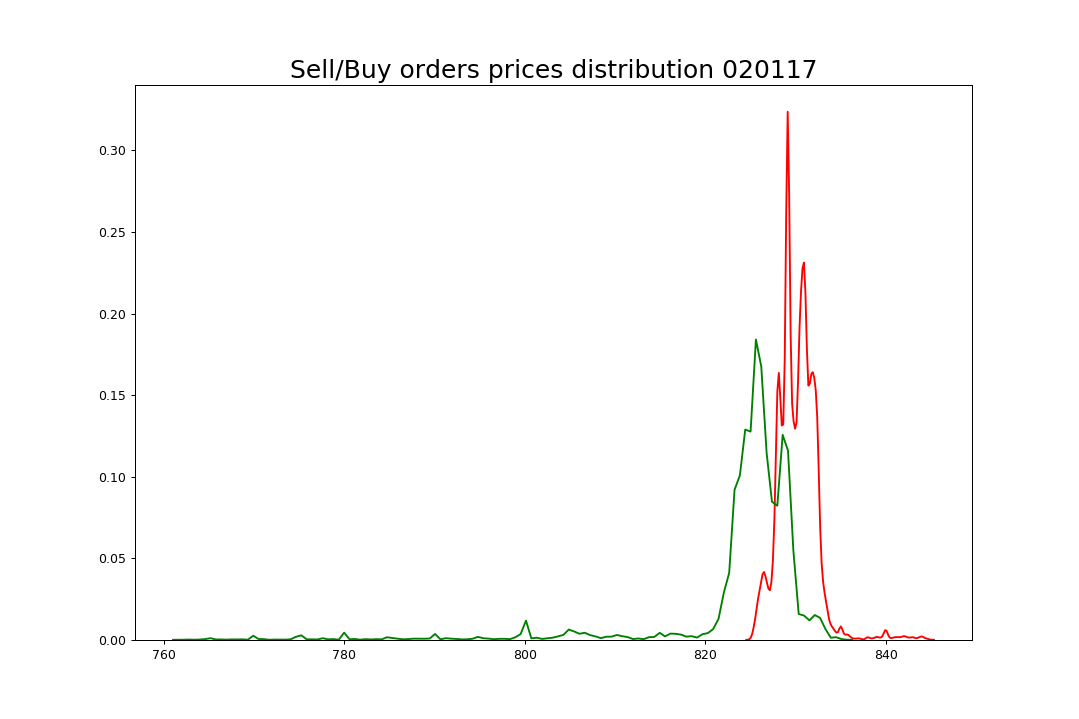

In [95]:
fig = plt.figure(figsize=(12,8))
ax = sns.distplot(capped_prices(lpriceOS),  kde=True, hist=False, color='r')
ax = sns.distplot(capped_prices(lpriceOB),  kde=True, hist=False, color='g')
plt.title('Sell/Buy orders prices distribution ' + itchday, fontsize=20)
plt.show()

<IPython.core.display.Javascript object>


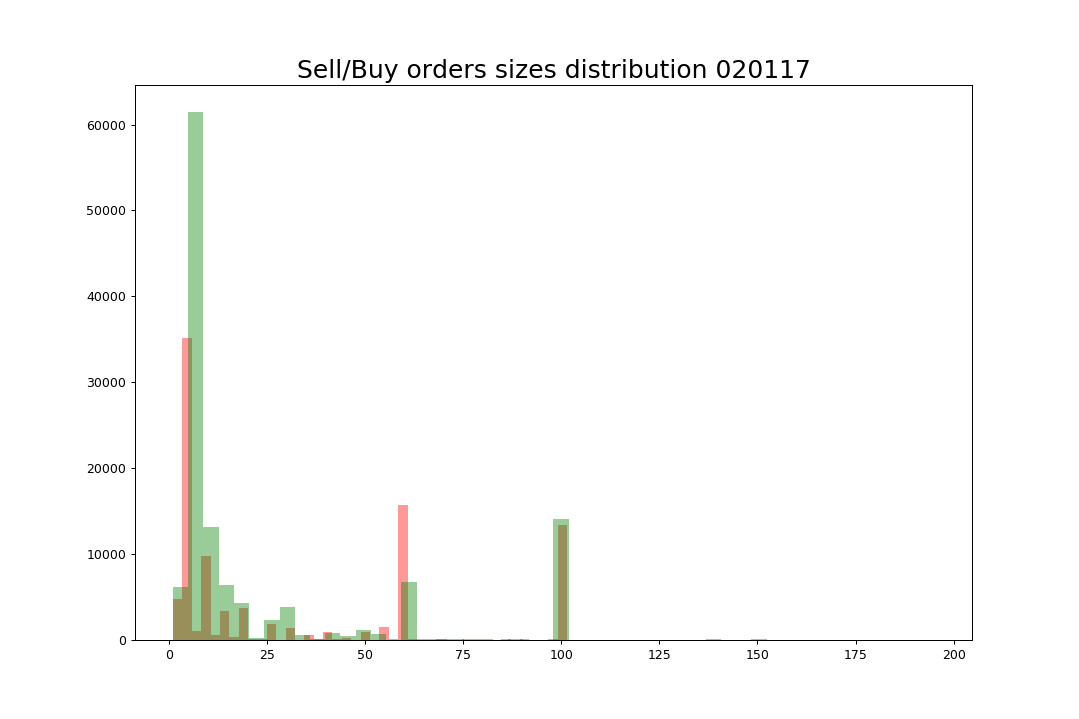

In [96]:
fig = plt.figure(figsize=(12,8))
ax = sns.distplot(capped_prices(lsizeOS),  kde=False, hist=True, color='r')
ax = sns.distplot(capped_prices(lsizeOB),  kde=False, hist=True, color='g')
plt.title('Sell/Buy orders sizes distribution ' + itchday, fontsize=20)
plt.show()

<IPython.core.display.Javascript object>


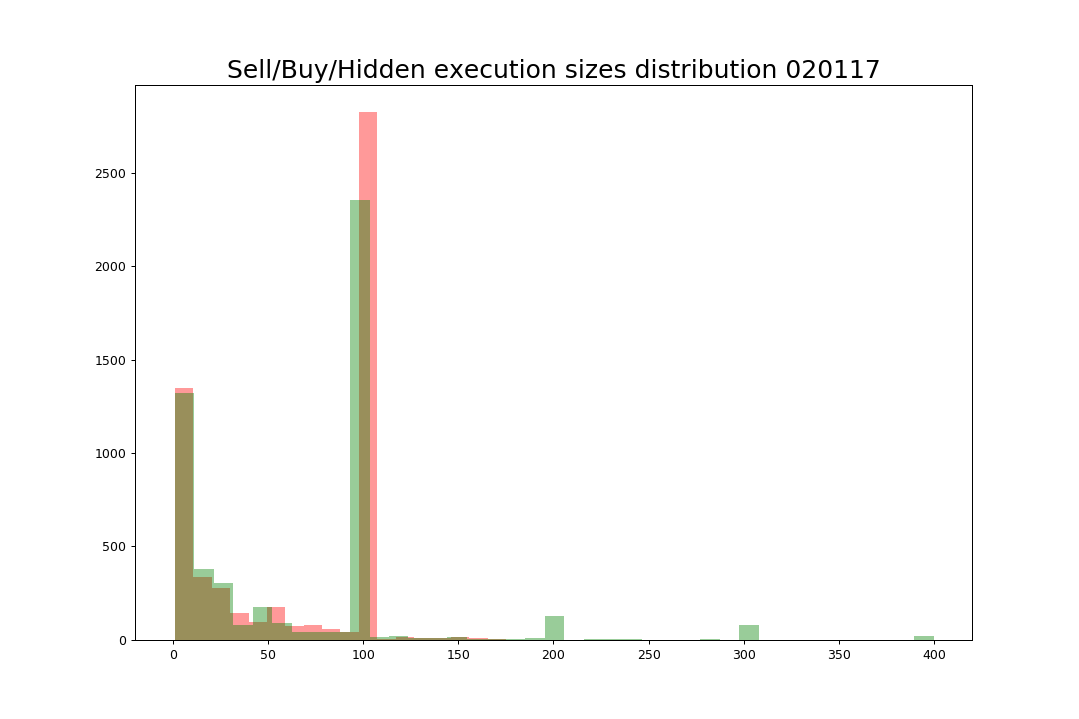

In [97]:
fig = plt.figure(figsize=(12,8))
ax = sns.distplot(capped_prices(lsizeES),  kde=False, hist=True, color='r')
ax = sns.distplot(capped_prices(lsizeEB),  kde=False, hist=True, color='g')
ax = sns.distplot(capped_prices(lsizeEP),  kde=False, hist=True, color='k')
plt.title('Sell/Buy/Hidden execution sizes distribution ' + itchday, fontsize=20)
plt.show()

<IPython.core.display.Javascript object>


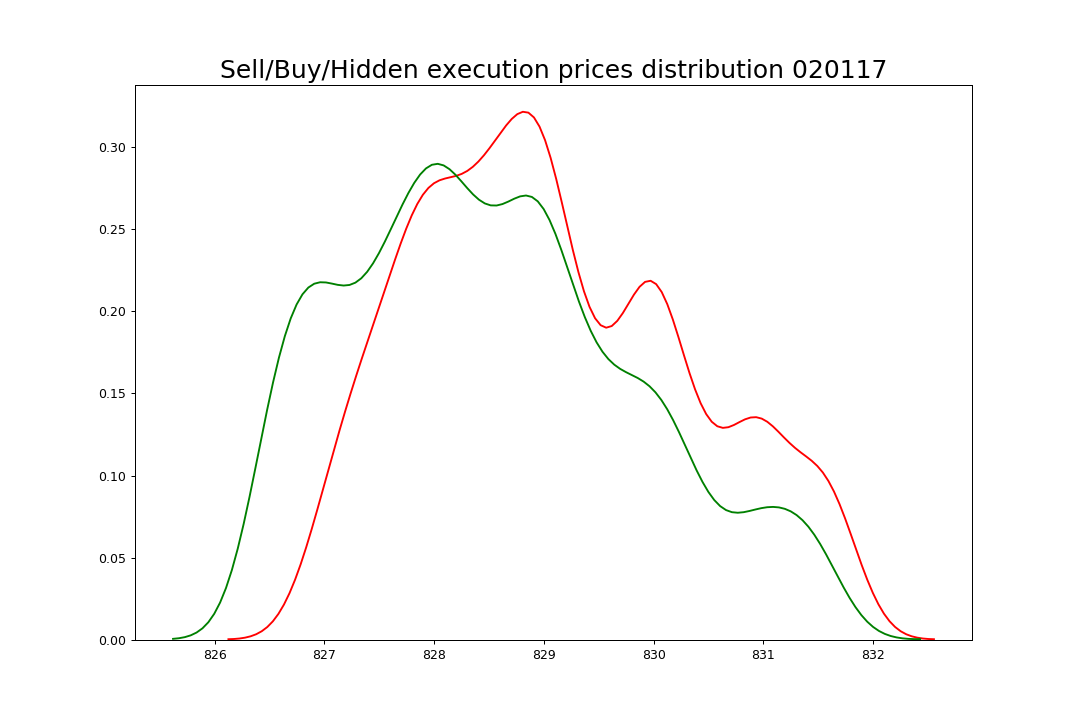

In [98]:
fig = plt.figure(figsize=(12,8))
ax = sns.distplot(capped_prices(lpriceES),  kde=True, hist=False, color='r')
ax = sns.distplot(capped_prices(lpriceEB),  kde=True, hist=False, color='g')
ax = sns.distplot(capped_prices(lpriceEP),  kde=True, hist=False, color='k')
plt.title('Sell/Buy/Hidden execution prices distribution ' + itchday, fontsize=20)
plt.show()

<IPython.core.display.Javascript object>


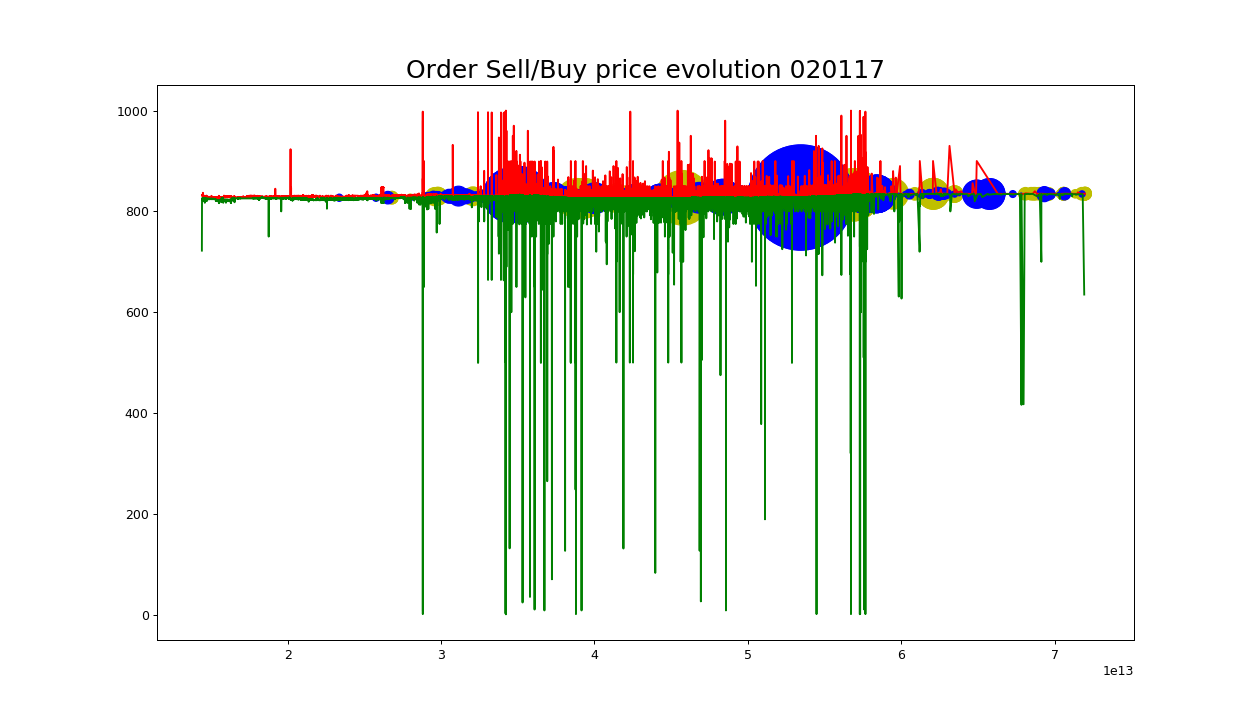

In [99]:
fig = plt.figure(figsize=(14,8))
plt.plot(ltimeOS, lpriceOS, color='r')
plt.plot(ltimeOB, lpriceOB, color='g')
plt.scatter(ltimeES, lpriceES,  marker='o', color='y', s=lsizeES)
plt.scatter(ltimeEB, lpriceEB,  marker='o', color='b', s=lsizeEB)
plt.scatter(ltimeEP, lpriceEP, marker='o', color='k', s=lsizeEP)

plt.title('Order Sell/Buy price evolution ' + itchday, fontsize=20)
plt.show()